This project investigates whether player characteristics such as age, gender, experience, and newsletter subscription status can predict how many hours a player contributes to the Minecraft server.

STEP 1: Loading Libraries and Visualizing Data

In [1]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Following this we can load and visualize the data

In [2]:
players <- read_csv("Data/players.csv")

head(players)
tail(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0.0,Rhys,Male,20
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


As shown above, the data contained player experience from Amateur to Pro, wether or not they are subscribed, the hashed email, their played hours, their names, gender and ages.

STEP 2: Data Cleaning and Preparation

Now that we have the data loaded we can see that it requires some cleaning, and since we are not using all the columns such as hashedEmail we can get rid of those. 

In [3]:
players_clean <- select(players, -hashedEmail, -name)
head(players_clean)

experience,subscribe,played_hours,gender,Age
<chr>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


Since our goal is to create a linear regression that attempts to predict played_hours using the other variables we need to turn variables such as experience, gender and subscription into factor variables. 

In [4]:
players_clean <- players_clean |>
    mutate(
        experience = as.factor(experience),
        subscribe = as.factor(subscribe), 
        gender = as.factor(gender)) |>
    rename(age = Age)
head(players_clean)

experience,subscribe,played_hours,gender,age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


Now the variables we want to use are factors which will help with our linear regression. I also renamed Age to age for consistency in names

STEP 3: Visualizing and Final Cleaning

Before building the needed elements for the regression it would be useful to have some idea of what the data looks like. First I will plot the hours played against the age of the participants showing different colours to differentiate the experience of the players and shape to show the gender. This will give us a solid understanding of the data before preparing the regression.

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because more
than 6 becomes difficult to discriminate
ℹ you have requested 7 values. Consider specifying shapes manually if you need
  that many have them.”
Warning message:
“Removed 17 rows containing missing values or values outside the scale range
(`geom_point()`).”


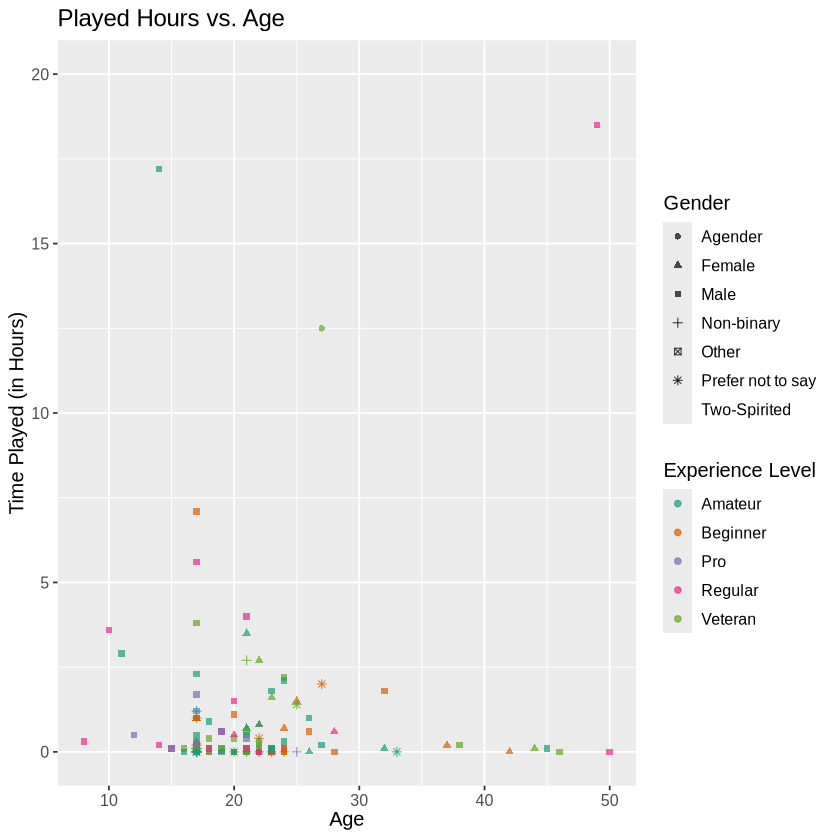

In [5]:
players_clean_plot <- players_clean |>
    ggplot(aes(x = age, y = played_hours, color = experience, shape = gender)) +
    geom_point(alpha = 0.7) +
    labs(x = "Age", y = "Time Played (in Hours)", color = "Experience Level",
        shape = "Gender", title = "Played Hours vs. Age") +
    theme(text = element_text(size = 12)) +
    ylim(0, 20) +
    scale_color_brewer(palette = "Dark2")

players_clean_plot

The graph above shows that initially just by looking at age vs time played there does not seem to be a lot of correlation in the data. However, we learnt something important which is that most of the time played data collected is concentrated in lower hours ~ 20 to 0 hours. This means that we have a few outliers outside of that data that can greatly affect our linear regression so we will not include those in our model.

In [6]:
players_clean <- players_clean |>
    filter(played_hours <= 20)

STEP 4: Building and Evaluating Linear Regression Model

Now that we have the data ready for the model we can create a recipe and the model specifications to create our linear regression. We will start with an initial split of the data

In [7]:
set.seed(32)

players_split <- initial_split(players_clean, prop = 0.75)
players_training <- training(players_split)
players_testing <- testing(players_split)

After our initial split, we can create a recipe and specify the linear regression model.

In [9]:
players_recipe <- recipe(played_hours ~ age + gender + experience + subscribe, data = players_training) |>
    step_dummy(all_nominal_predictors())

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

Now that we have the models we can just add it to a workflow and fit the model

In [13]:
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(lm_spec) |>
    fit(data = players_training)

players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
             (Intercept)                       age             gender_Female  
                 7.09777                  -0.02125                  -5.92770  
             gender_Male         gender_Non.binary              gender_Other  
                -5.87636                  -5.92750                        NA  
gender_Prefer.not.to.say       gender_Two.Spirited       experience_Beginner  
                -5.77631                  -6.59794                  -0.40387  
          experience_Pro        experience_Regular        experience_Veteran  
                -0.47043                  -0.29354                 

Given this data, we get our coefficients for the linear formula however, given that we used so many variables it would be quite long and difficult to visualize. Now we can evaluate the model on the test data.  

In [16]:
players_predictions <- predict(players_fit, players_testing) |>
  bind_cols(players_testing)

metrics <- (metrics(players_predictions, truth = played_hours, estimate = .pred)) |>
    filter(.metric == "rmse") |>
    select(.estimate)
metrics

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response", :
“prediction from rank-deficient fit; consider predict(., rankdeficient="NA")”


.estimate
<dbl>
3.04623


We find that RMSE of about 3 hours which means an average error of 3 hours which is not bad but it could be improved upon. Let's visualize this data.